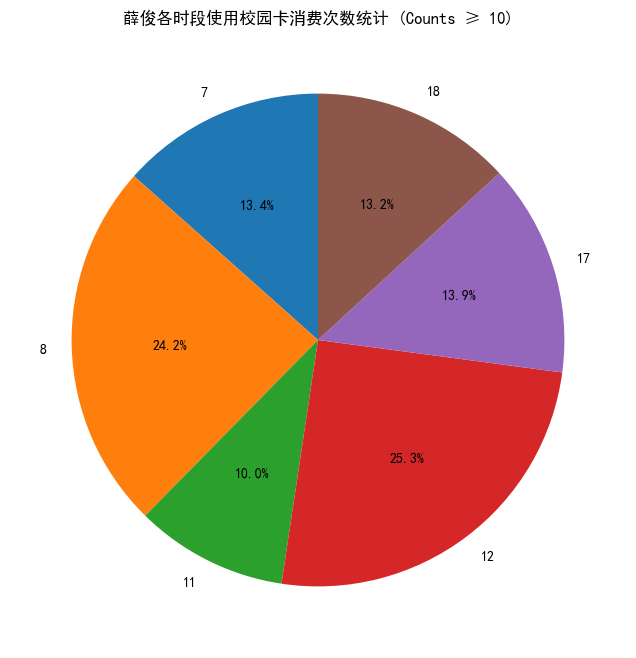

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载数据
file_path = 'transactions.csv'
data = pd.read_csv(file_path)

# 将 'jndatetime' 列转换为 datetime 格式并考虑时区，提取小时数
data['Hour'] = pd.to_datetime(data['jndatetime'], utc=True).dt.tz_convert('Asia/Shanghai').dt.hour

# 计算每个小时的交易次数
hour_counts = data['Hour'].value_counts().sort_index()

# 确保所有小时都表示出来，即使某些小时没有交易
all_hours = pd.Series(range(24))  # 一天中的所有小时
hour_counts = hour_counts.reindex(all_hours, fill_value=0)  # 重新索引所有小时，填充缺失值为0

# 过滤掉计数小于10的小时
filtered_hour_counts = hour_counts[hour_counts >= 10]

# 绘制扇形图，显示过滤后的小时计数
plt.figure(figsize=(10, 8))
plt.pie(filtered_hour_counts, labels=filtered_hour_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('薛俊各时段使用校园卡消费次数统计 (Counts ≥ 10)')
plt.show()

In [4]:
# 转换 'tranamt' 列，从分转换为元
data['TransactionAmount'] = data['tranamt'] / 100

# 过滤出交易次数大于10的小时
active_hours = hour_counts[hour_counts > 10].index

# 选择这些小时的数据进行进一步分析
active_data = data[data['Hour'].isin(active_hours)]

# 按小时分组计算统计量
stats = active_data.groupby('Hour')['TransactionAmount'].agg(['mean', 'var', 'median'])

# 打印结果
stats

,mean,var,median
Hour,,,
7,2.501961,2.333396,2.00
8,2.371739,1.628204,2.00
11,9.581579,5.892354,9.30
12,10.020104,25.596102,9.40
17,7.152830,56.170232,5.80
18,5.246000,13.024984,3.75


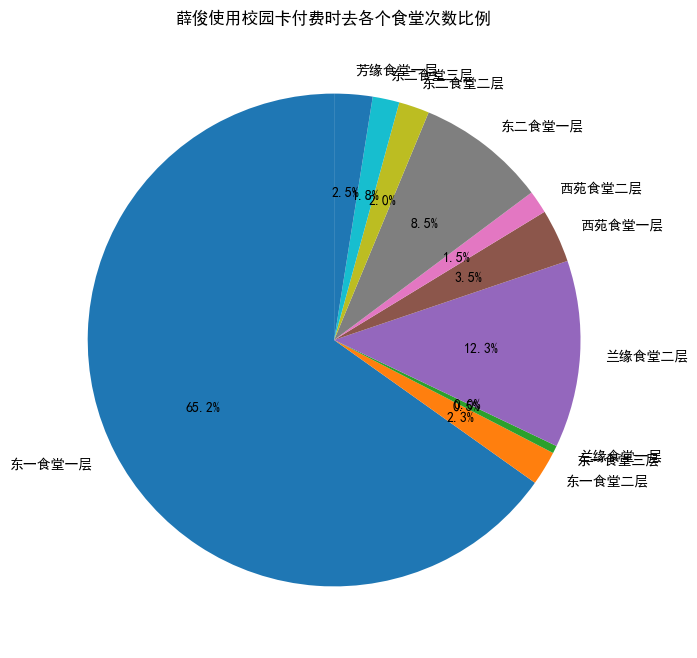

{'东一食堂一层': 260,
 '东一食堂二层': 9,
 '东一食堂三层': 2,
 '兰缘食堂一层': 0,
 '兰缘食堂二层': 49,
 '西苑食堂一层': 14,
 '西苑食堂二层': 6,
 '东二食堂一层': 34,
 '东二食堂二层': 8,
 '东二食堂三层': 7,
 '芳缘食堂一层': 10}

In [7]:
# 创建食堂列表
canteens = [
    "东一食堂一层", "东一食堂二层", "东一食堂三层",
    "兰缘食堂一层", "兰缘食堂二层",
    "西苑食堂一层", "西苑食堂二层",
    "东二食堂一层", "东二食堂二层", "东二食堂三层",
    "芳缘食堂一层"
]

# 初始化字典来计数
canteen_counts = {canteen: 0 for canteen in canteens}

# 遍历食堂列表，计算每个食堂的频数
for canteen in canteens:
    canteen_counts[canteen] = data['resume'].str.contains(canteen).sum()

# 绘制扇形图
plt.figure(figsize=(10, 8))
plt.pie(canteen_counts.values(), labels=canteen_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title('薛俊使用校园卡付费时去各个食堂次数比例')
plt.show()

# 打印计数结果
canteen_counts

In [9]:
# 提取食堂及窗口号
extracted_data = data['resume'].str.extract(r'(东一食堂一层|东一食堂二层|东一食堂三层|兰缘食堂一层|兰缘食堂二层|西苑食堂一层|西苑食堂二层|东二食堂一层|东二食堂二层|东二食堂三层|芳缘食堂一层)\s*(\d+号)')

# 生成一个新列为食堂加窗口号
data['CanteenCounter'] = extracted_data[0] + " " + extracted_data[1]

# 统计频数并排序
canteen_counter_freq = data['CanteenCounter'].value_counts().sort_values(ascending=False)

# 计算每个食堂窗口的消费均值、中位数和方差
stats_by_counter = data.groupby('CanteenCounter')['TransactionAmount'].agg(['mean', 'median', 'var']).dropna()

# 合并频数、消费均值、中位数和方差的表
combined_stats = pd.concat([canteen_counter_freq, stats_by_counter], axis=1)
combined_stats.columns = ['Frequency', 'Mean', 'Median', 'Variance']

# 按频数从多到少排序
combined_stats_sorted = combined_stats.sort_values(by='Frequency', ascending=False)

combined_stats_sorted

,Frequency,Mean,Median,Variance
东一食堂一层 23号,53,1.832075,1.5,0.261836
东一食堂一层 29号,41,1.958537,2.0,0.230488
东一食堂一层 31号,34,1.970588,2.0,0.029412
东一食堂一层 28号,24,2.116667,2.0,2.187536
东一食堂一层 24号,24,4.354167,3.5,6.945199
...,...,...,...,...
东二食堂一层 32号,1,NaN,NaN,NaN
西苑食堂一层 7号,1,NaN,NaN,NaN
西苑食堂一层 47号,1,NaN,NaN,NaN
东二食堂三层 63号,1,NaN,NaN,NaN
